In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
# Set global font settings
plt.rcParams["font.family"] = "Times New Roman"
matplotlib.rcParams['figure.dpi'] = 300
from utils import make_da, valid2All, get_processed_da, rotate_and_crop

def plotCropTraits(year):
    # 1. Load Data
    df = pd.read_csv(f'Coords/Grid_geo_center_coordinates.csv')
    df_BBCH = pd.read_csv(f'Estimated_crop_trait_maps/Grid1598_BBCH{year}.txt', sep=r'\s+')
    df_biomass = pd.read_csv(f'Estimated_crop_trait_maps/Grid1598_Biomass{year}.txt', sep=r'\s+')
    df_LAI = pd.read_csv(f'Estimated_crop_trait_maps/Grid1598_gLAI{year}.txt', sep=r'\s+')
    valid = np.loadtxt('Estimated_crop_trait_maps/validGrid.txt').astype(np.int32).tolist()

    # 2. Identify Dates
    bbch_cols = set(df_BBCH.columns)
    bio_cols = set(df_biomass.columns)
    lai_cols = set(df_LAI.columns)
    if year==2017:
        common_dates = sorted(list(bbch_cols.intersection(bio_cols).intersection(lai_cols)))[:-1]
    elif year==2018:
        common_dates = sorted(list(bbch_cols.intersection(bio_cols).intersection(lai_cols)))[1:]
    # 3. Setup Plotting
    n_dates = len(common_dates)
    rows = 3

    # Figure sizing: Narrower width because vertical maps take less space
    fig, axes = plt.subplots(
        nrows=rows, 
        ncols=n_dates, 
        figsize=(n_dates * 1.2, rows * 3.5), # Adjusted aspect ratio
        gridspec_kw={'wspace': 0.02, 'hspace': 0.05}, # Tighter spacing
        constrained_layout=False 
    )

    if n_dates == 1: axes = axes[:, np.newaxis]

    row_configs = [
        {"df": df_BBCH, "label": "Phenology (BBCH)", "cmap": "RdYlGn", "row_idx": 0},
        {"df": df_biomass, "label": "Biomass (ton/ha)", "cmap": "RdYlGn", "row_idx": 1},
        {"df": df_LAI, "label": "LAI (m2/m2)", "cmap": "RdYlGn", "row_idx": 2}
    ]

    # Rotation Angle: 45 degrees usually turns a SW-NE diagonal to vertical
    ANGLE = -30 
    y_displacement = [0,-0.03,-0.06]
    for i,config in enumerate(row_configs):
        row = config["row_idx"]
        source_df = config["df"]
        label = config["label"]
        cmap = config["cmap"]
        
        # Calculate global scale
        all_values = source_df[common_dates].values.flatten()
        valid_values = all_values[all_values >= 0]
        if len(valid_values) > 0:
            vmin, vmax = np.percentile(valid_values, 2), np.percentile(valid_values, 98)
        else:
            vmin, vmax = 0, 1

        for col, date in enumerate(common_dates):
            ax = axes[row, col]
            
            # 1. Get standard DataArray (Original Coordinates)
            da = get_processed_da(source_df, date, valid, df)
            
            # 2. Rotate the IMAGE ARRAY directly
            img_data = rotate_and_crop(da, angle=ANGLE)
            
            # 3. Plot using imshow (since coordinates are now arbitrary pixels)
            im = ax.imshow(
                img_data,
                cmap=cmap,
                vmin=vmin,
                vmax=vmax,
                origin='lower', # Ensures map isn't flipped upside down
                aspect='equal'
            )
            
            # Styling
            ax.set_frame_on(False)
            ax.set_xticks([])
            ax.set_yticks([])
            
            if row == 0:
                # Rotated text to fit tight spacing
                ax.set_title(date, fontsize=11, fontweight='bold', rotation=45, ha='left')
            if col == 0:
                ax.set_ylabel(label, fontsize=16, fontweight='bold', labelpad=5)

        # Colorbar at end of row
        # We use the position of the last axis to place the colorbar
        pos = axes[row, -1].get_position()
        cbar_height = pos.height * 1
        cbar_bottom = pos.y0 + y_displacement[i]
        cbar_width = 0.015
        cbar_left = pos.x1 + 0.05
        
        cax = fig.add_axes([cbar_left, cbar_bottom, cbar_width, cbar_height])

        cbar = fig.colorbar(im, cax=cax)
        cbar.set_label(label, size=11)
        cbar.ax.tick_params(labelsize=8)

    plt.subplots_adjust(left=0.08, right=0.92, top=0.90, bottom=0.05)
    plt.show()


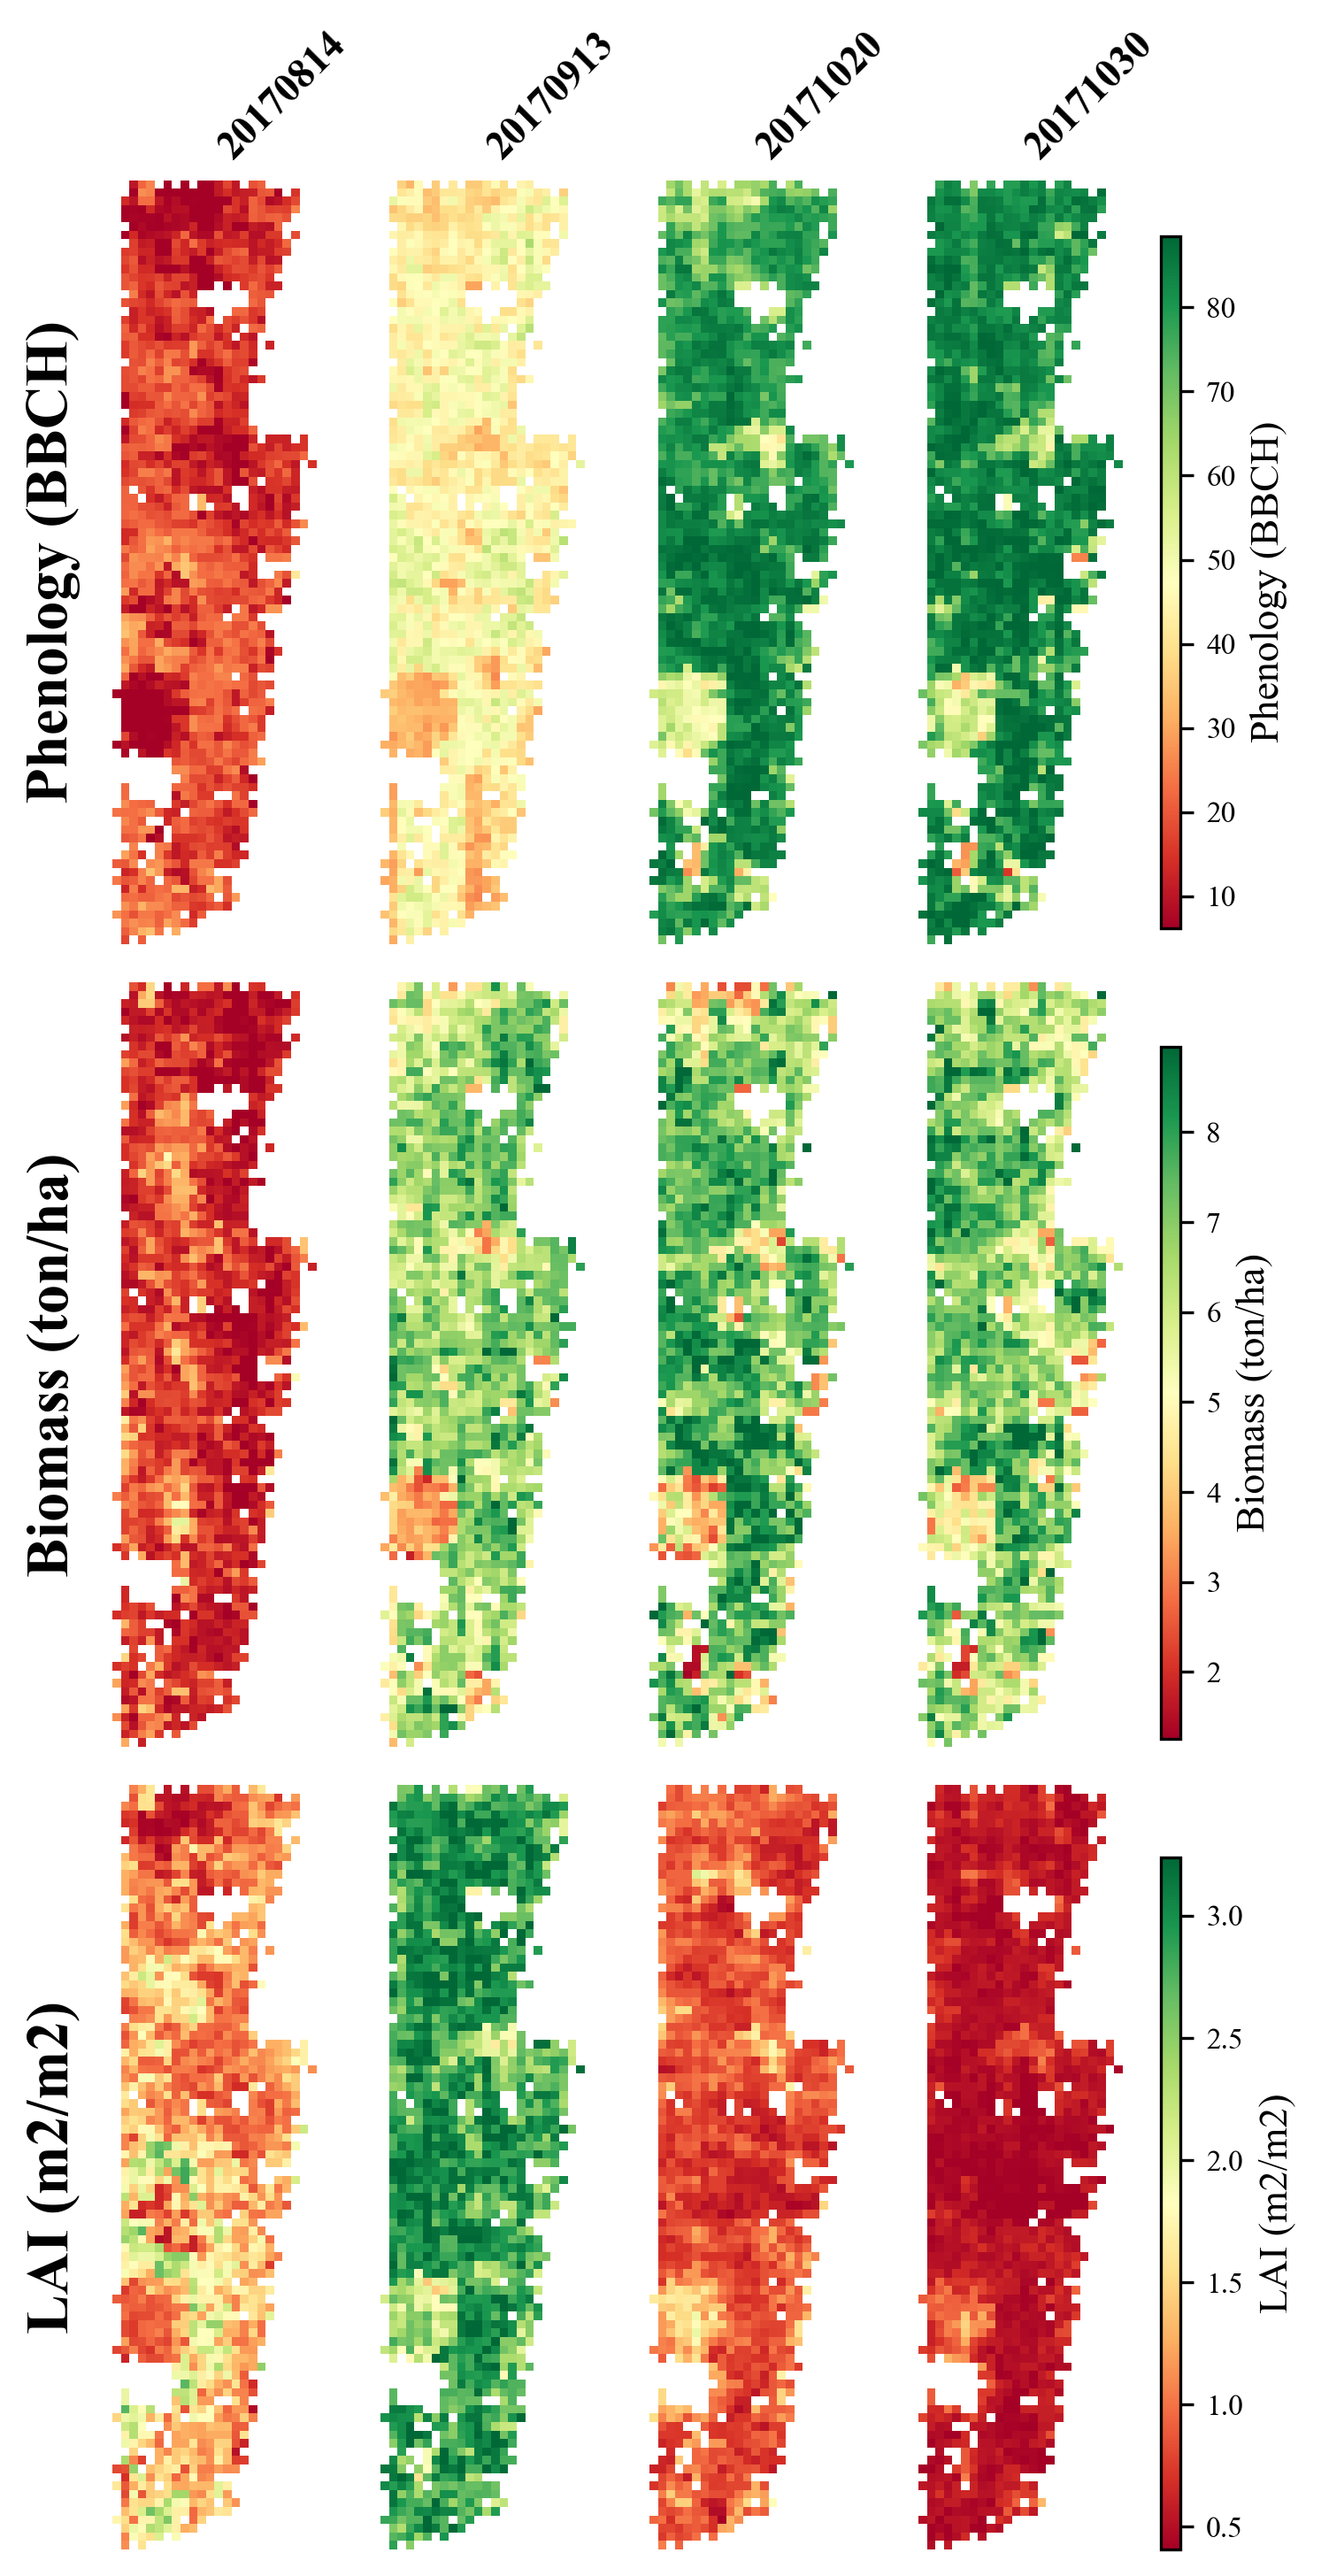

In [2]:
plotCropTraits(year=2017)

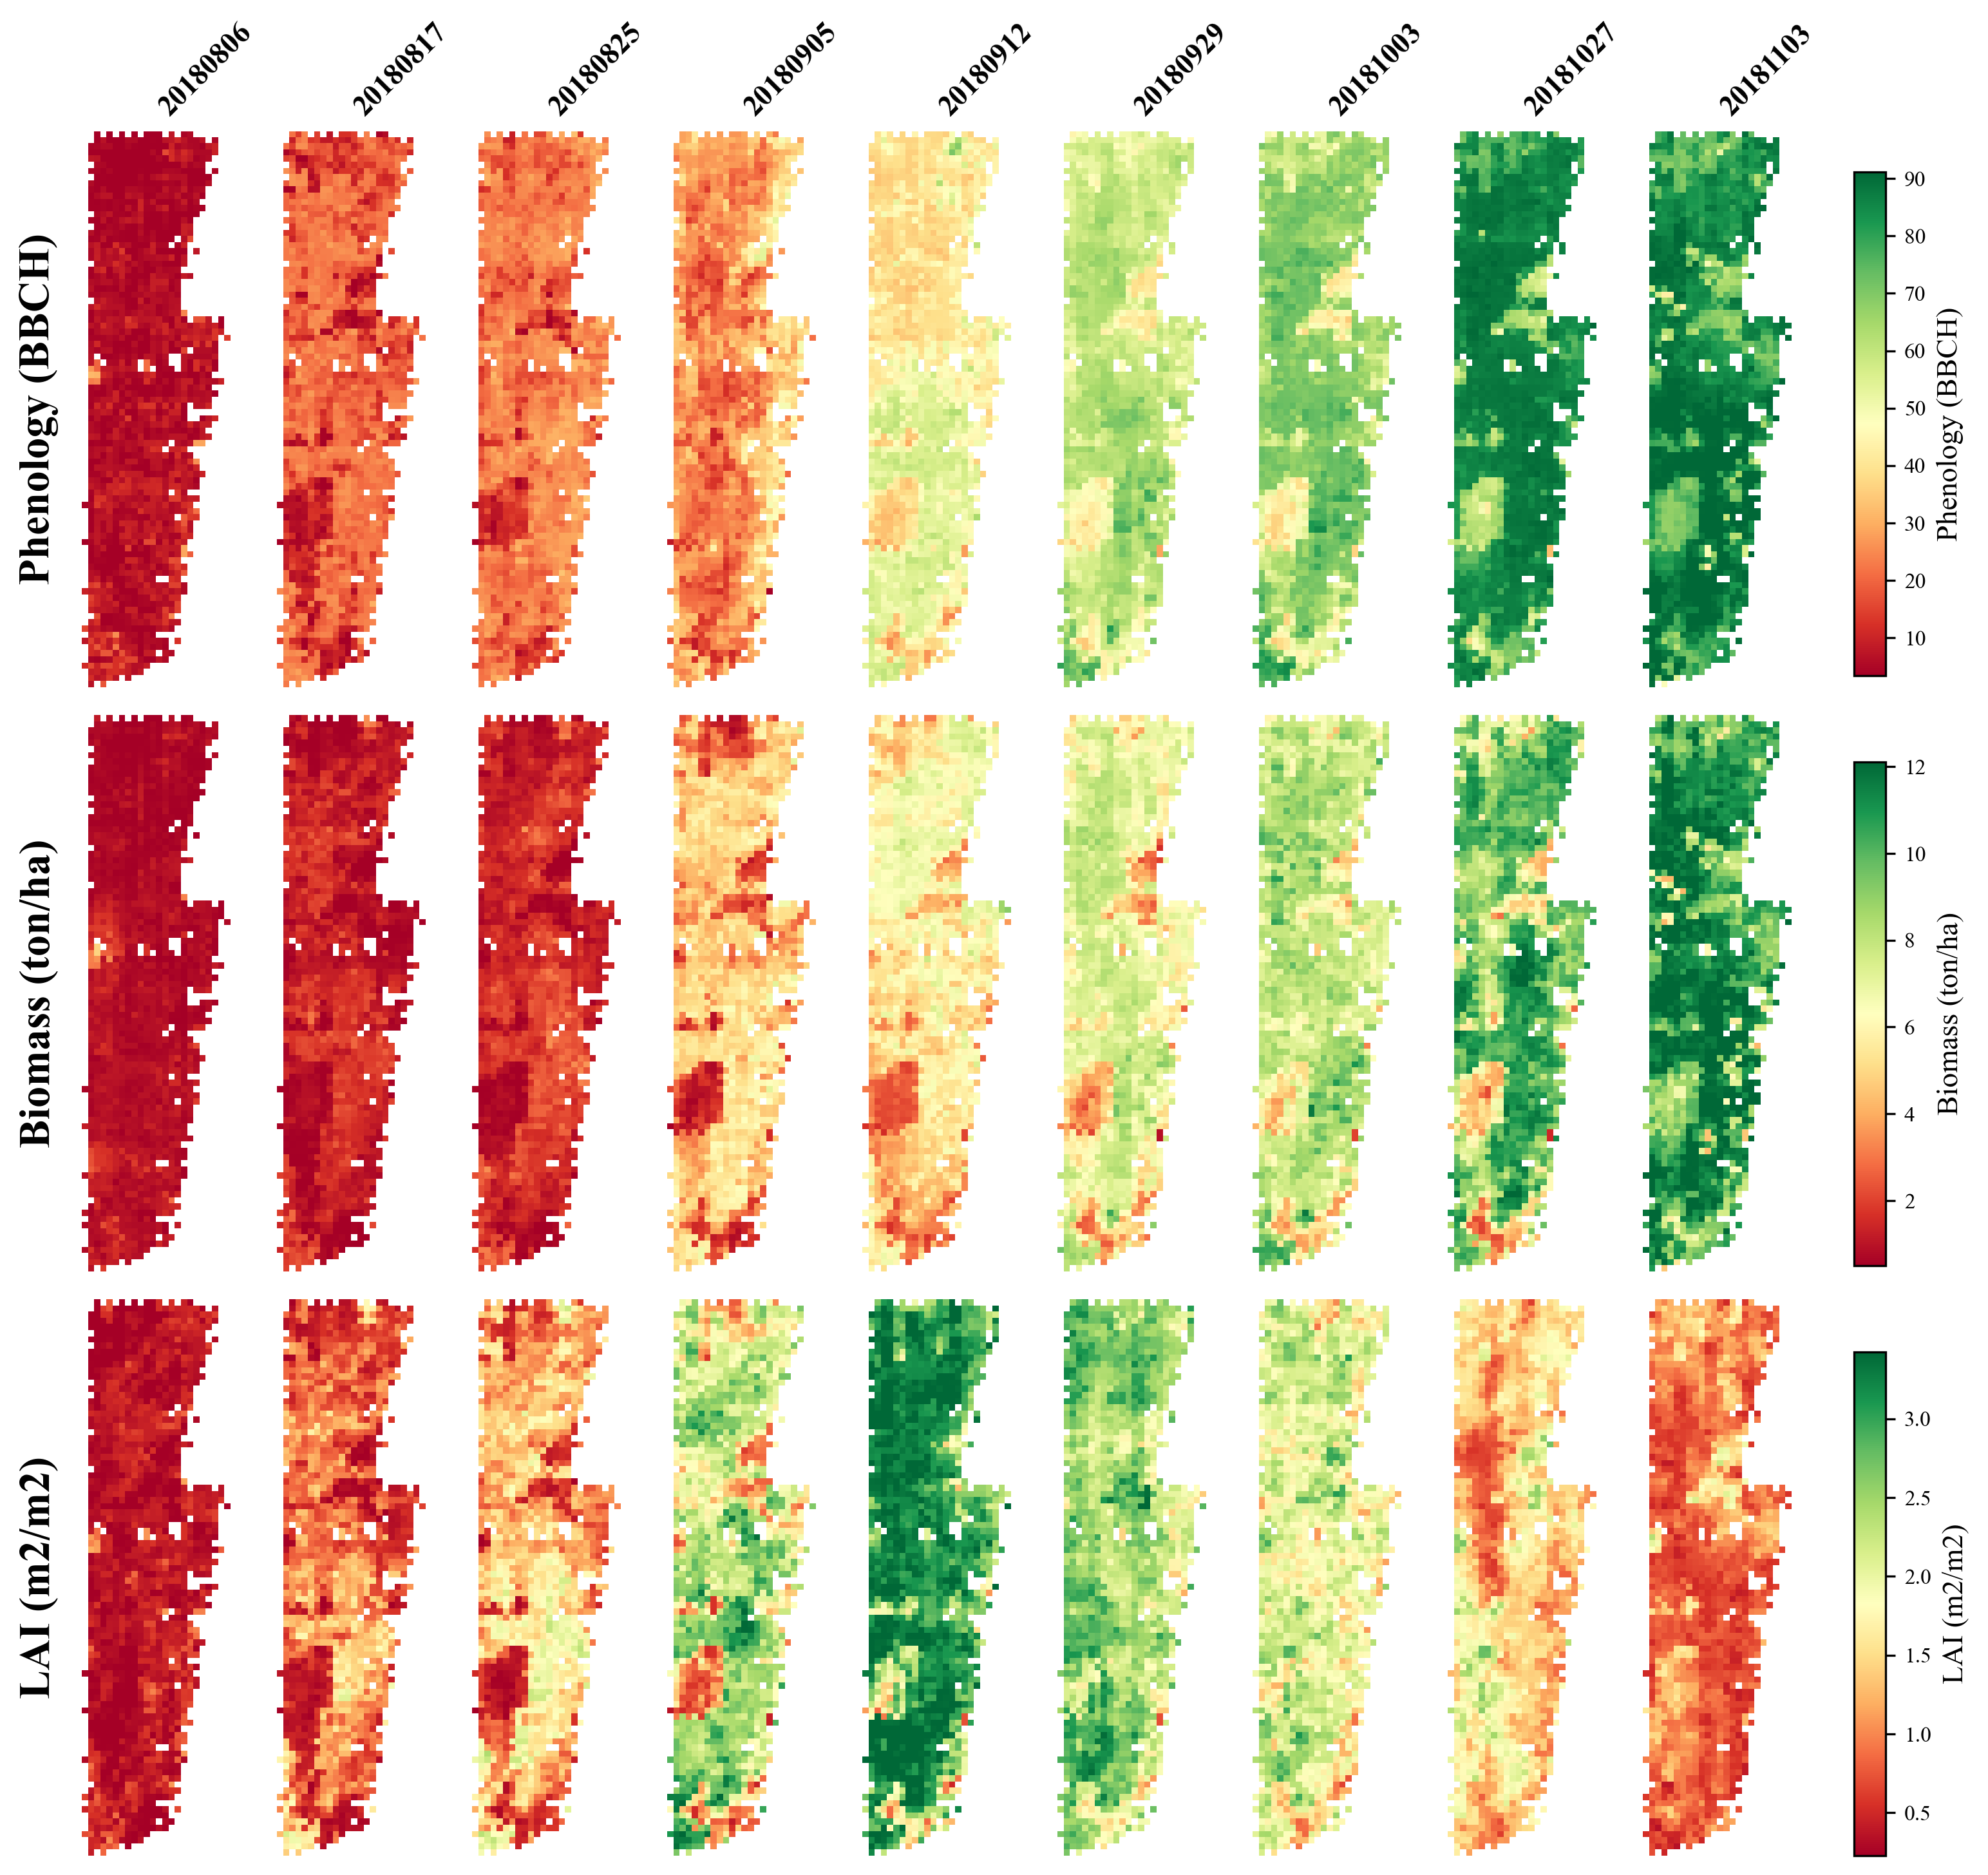

In [3]:
plotCropTraits(year=2018)